In [252]:
!pip3 install pandas numpy matplotlib seaborn sklearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing

In [253]:
# load dataset from a1_dataset.csv
df = pd.read_csv('a1_dataset.csv')


### Encoding categorical values

In [254]:
# encode column var3 using ordinary encoder

values_var3 = df["var3"].unique()
dict_var3 = {values_var3[i]: i for i in range(len(values_var3))}


def encode_var3(value: str) -> int:
    return dict_var3[value]


def decode_var3(encoded: int) -> str:
    return values_var3[encoded]


In [255]:
# apply encoding on var3 column
df.loc[:, "var3"] = df.loc[:, "var3"].apply(encode_var3)

df.head()

,target,var1,var2,var3,var4,var5,var6,var7
0,0,509.18,417.681,0,138.0,393.00,no,2019-07-20 13:21:37
1,0,446.06,666.182,1,81.0,352.05,yes,2019-04-04 21:30:46
2,1,235.50,398.097,2,90.0,339.00,no,2019-03-03 02:59:37
3,0,306.02,518.163,3,102.0,439.25,yes,2019-03-19 08:00:58
4,0,453.08,600.156,4,105.0,422.95,no,2019-03-18 13:22:35


In [256]:
# encode var6

def encode_var6(value: str) -> int:
    return 0 if value == "no" else 1

def decode_var6(encoded: int) -> str:
    return "no" if encoded == 0 else "yes"

df.loc[:, "var6"] = df.loc[:, "var6"].apply(encode_var6)
df.head()

,target,var1,var2,var3,var4,var5,var6,var7
0,0,509.18,417.681,0,138.0,393.00,0,2019-07-20 13:21:37
1,0,446.06,666.182,1,81.0,352.05,1,2019-04-04 21:30:46
2,1,235.50,398.097,2,90.0,339.00,0,2019-03-03 02:59:37
3,0,306.02,518.163,3,102.0,439.25,1,2019-03-19 08:00:58
4,0,453.08,600.156,4,105.0,422.95,0,2019-03-18 13:22:35


In [257]:
# # drop var7 column
# df = df.drop(columns=["var7"])

# preprocess var7

# we want to use var7 as datetime
df.loc[:, "var7"] = pd.to_datetime(df.loc[:, "var7"], errors='coerce')

# count how many NaNs are in var7
nulls = df.loc[:, "var7"].isnull().sum()
print(f"There are {nulls} wrong datetimes in var7")

# remove NaT rows
df = df.loc[~df.loc[:, "var7"].isnull(), :]

There are 5 wrong datetimes in var7


In [258]:
# encode var7
# link to source where I found how to do it: https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/
# I will add 6 new columns: year, day in the year, seconds in the day

# df.loc[:, "month"] = df.loc[:, "var7"].dt.month
# df.loc[:, "dayofmonth"] = df.loc[:, "var7"].dt.day
# df.loc[:, "dayofweek"] = df.loc[:, "var7"].dt.dayofweek

# # get how many days are in one year
# days_in_year = np.array([pd.Timestamp(year, 12, 31).dayofyear for year in df.loc[:, "var7_year"]])

# # add 2 columns day_cos and day_sin
# df.loc[:, "var7_day_cos"] = np.cos(2 * np.pi * df.loc[:, "var7"].dt.dayofyear / days_in_year)
# df.loc[:, "var7_day_sin"] = np.sin(2 * np.pi * df.loc[:, "var7"].dt.dayofyear / days_in_year)

# # add 2 columns seconds_cos and seconds_sin
# seconds = df.loc[:, "var7"].dt.hour * 3600 + df.loc[:, "var7"].dt.minute * 60 + df.loc[:, "var7"].dt.second
# df.loc[:, "var7_seconds_cos"] = np.cos(2 * np.pi * seconds / 86400)
# df.loc[:, "var7_seconds_sin"] = np.sin(2 * np.pi * seconds / 86400)

# drop var7 as it was already encoded
df = df.drop(columns=["var7"])


In [259]:
df.head()

,target,var1,var2,var3,var4,var5,var6
0,0,509.18,417.681,0,138.0,393.00,0
1,0,446.06,666.182,1,81.0,352.05,1
2,1,235.50,398.097,2,90.0,339.00,0
3,0,306.02,518.163,3,102.0,439.25,1
4,0,453.08,600.156,4,105.0,422.95,0


In [260]:
df.cov()

,target,var1,var2,var3,var4,var5,var6
target,0.250261,-34.466283,-33.389155,-0.329979,6.825214,-29.536927,0.012037
var1,-34.466283,7720.665411,4086.283818,286.093765,-929.332053,3603.302521,-1.785369
var2,-33.389155,4086.283818,18205.123489,42.279454,-842.429735,3505.217790,-0.161071
var3,-0.329979,286.093765,42.279454,4243.916818,-134.632308,114.349509,-0.230043
var4,6.825214,-929.332053,-842.429735,-134.632308,693.044786,-791.970675,0.236296
var5,-29.536927,3603.302521,3505.217790,114.349509,-791.970675,6238.041880,0.594552
var6,0.012037,-1.785369,-0.161071,-0.230043,0.236296,0.594552,0.249845


### Data imputation

In [261]:
df.loc[:, "var4"].count(), df.count()

(325,
 target    920
 var1      920
 var2      920
 var3      920
 var4      325
 var5      920
 var6      920
 dtype: int64)

In [262]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [263]:
# split data on what we have to train on and what we have to predict

df_test = df[df.loc[:, "var4"].notnull()]
Y_test = df_test.loc[:, "var4"]
X_test = df_test.drop(columns=["var4"])

df_predict = df[df.loc[:, "var4"].isnull()]
X_predict = df_predict.drop(columns=["var4"])

Degree 0
MSE = 6.98e+02(+/- 1.32e+02)
Degree 1
MSE = 5.20e+02(+/- 9.19e+01)
Degree 2
MSE = 7.84e+02(+/- 1.95e+02)


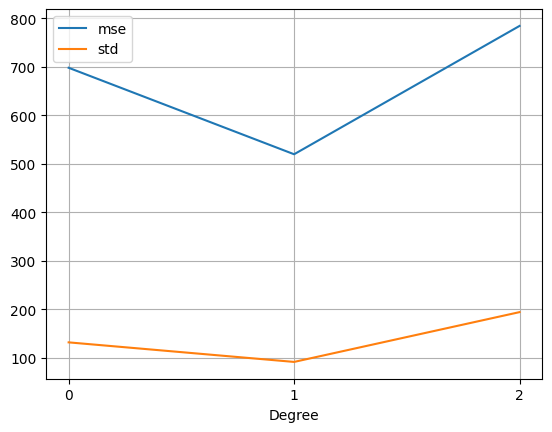

In [264]:
# find polynomial degree which best fits the polynomial regression


degrees = [0, 1, 2]
result = []

for degree in degrees:
    polynomial_features = PolynomialFeatures(degree=degree)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    scores = cross_val_score(
        pipeline, X_test, Y_test, scoring="neg_mean_squared_error", cv=4
    )
    print(
        "Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
            degree, -scores.mean(), scores.std()
        )
    )
    result.append({"mse": -scores.mean(), "std": scores.std()})

# plot MSE for each degree

plt.grid()
plt.plot(degrees, [r["mse"] for r in result], label="mse")
plt.plot(degrees, [r["std"] for r in result], label="std")
plt.xlabel("Degree")
plt.xticks(degrees)

plt.legend()
plt.show()


ну хуё моё степень 1 прям заебись

In [265]:
# fill null values with model with degree 1

polynomial_features = PolynomialFeatures(degree=1)
linear_regression = LinearRegression()

pipeline = Pipeline(
    [
        ("polynomial_features", polynomial_features),
        ("linear_regression", linear_regression),
    ]
)

# predict values
pipeline.fit(X_test, Y_test)
Y_predict = pipeline.predict(X_predict)

df.loc[df.loc[:, "var4"].isnull(), "var4"] = Y_predict

df.head()


,target,var1,var2,var3,var4,var5,var6
0,0,509.18,417.681,0,138.0,393.00,0
1,0,446.06,666.182,1,81.0,352.05,1
2,1,235.50,398.097,2,90.0,339.00,0
3,0,306.02,518.163,3,102.0,439.25,1
4,0,453.08,600.156,4,105.0,422.95,0


In [266]:
# PCA should act like a common PCA from sklearn, but from scracch
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sympy import Q


class PCA_custom:
    def __init__(self, n_components: int):
        self.n_components = n_components
        self.eigenvalues = None
        self.eigenvectors = None
        self.components_ = None

    def fit(self, X: np.ndarray):
        # standardize data
        X_scaled = X

        scaler = StandardScaler()
        scaler.fit(X_scaled)
        self.scaler = scaler

        X_scaled = scaler.transform(X_scaled)
        # scaler = MinMaxScaler()
        # X_scaled = scaler.fit_transform(X_scaled)

        # calculate covariance matrix
        cov_matrix = np.cov(X_scaled.T)

        # calculate eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

        # sort eigenvalues and eigenvectors
        idx = eigenvalues.argsort()[::-1]
        self.components_ = idx[: self.n_components]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # save eigenvalues and eigenvectors
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors

    def transform(self, X: np.ndarray) -> np.ndarray:
        # standardize data
        X_scaled = X

        # scaler = StandardScaler()
        X_scaled = self.scaler.transform(X_scaled)

        # scaler = MinMaxScaler()
        # X_scaled = scaler.fit_transform(X_scaled)

        # calculate explained variance
        explained_variance = self.eigenvalues / np.sum(self.eigenvalues)

        # calculate components
        components = self.eigenvectors[:, : self.n_components]

        # calculate transformed data
        X_transformed = np.dot(X_scaled, components)

        return X_transformed


<AxesSubplot:xlabel='var1', ylabel='var6'>

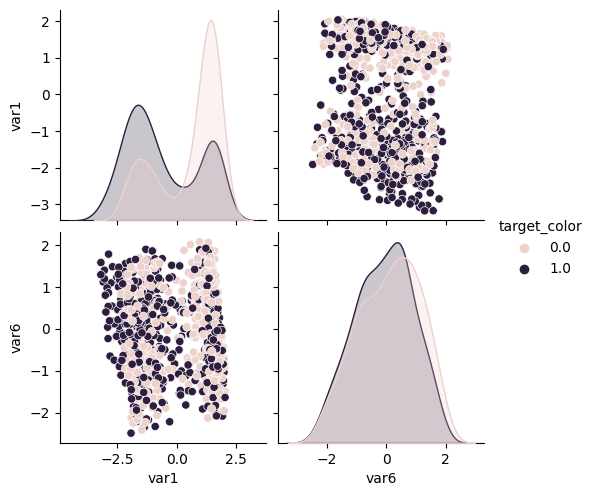

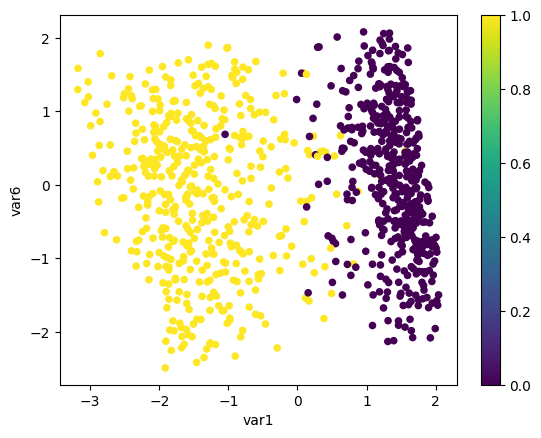

In [267]:
# apply PCA

from sklearn.decomposition import PCA


X = df.drop(columns=["target"])
Y = df.loc[:, "target"]

pca = PCA_custom(n_components=2)
pca.fit(X)

X_pca = pca.transform(X)

# plot data using seaborn in 3d
df_pca = pd.DataFrame(X_pca, columns=[X.columns[i] for i in pca.components_])
df_pca["target_color"] = Y

sns.pairplot(df_pca, hue="target_color")

df_pca.plot.scatter(x=X.columns[pca.components_[0]], y=X.columns[pca.components_[1]], c=Y, cmap="viridis")

<AxesSubplot:>

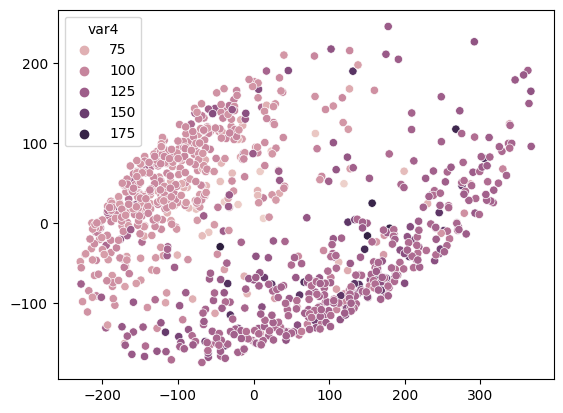

In [103]:
# apply PCA

from sklearn.decomposition import PCA

X, Y = df.loc[:, ["var1", "var2", "var3", "var5", "var6"]], df.loc[:, "var4"]

pca = PCA(n_components=2)
pca.fit(df)

X_pca = pca.transform(df)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=Y)

<AxesSubplot:>

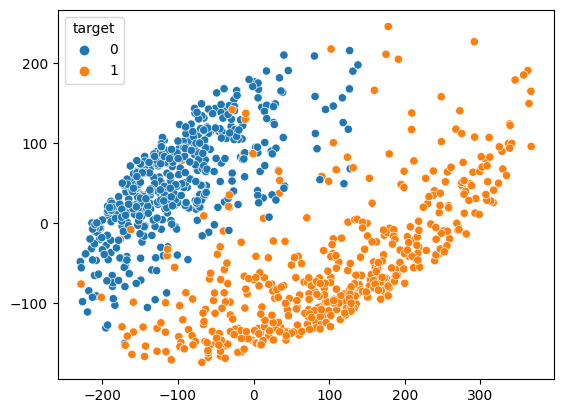

In [104]:

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df.loc[:, "target"])

### выглядит ахуенно

## тюнинг этой хуеты

In [105]:
# implement logistic regression to predict target column and test it

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X, Y = df.loc[:, ["var1", "var2", "var3", "var5", "var6"]], df.loc[:, "target"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, Y_train)

print("Train score: ", logistic_regression.score(X_train, Y_train))


Train score:  0.9581081081081081


In [106]:
# implement classification using logistic regression and tune its parameters using grid search

from sklearn.model_selection import GridSearchCV

X, Y = df.loc[:, ["var1", "var2", "var3", "var5", "var6"]], df.loc[:, "target"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

logistic_regression = LogisticRegression()

parameters = {
    "penalty": ["l1", "l2"],
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    
}

grid_search = GridSearchCV(logistic_regression, parameters, cv=3)
grid_search.fit(X_train, Y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
print("Test score: ", grid_search.score(X_test, Y_test))



Best parameters:  {'C': 1, 'penalty': 'l2'}
Best score:  0.9594757688467573
Test score:  0.9567567567567568


/home/leo/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
21 fits failed out of a total of 42.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/home/leo/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/leo/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/leo/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 61, in _check_solver
    raise ValueErro

In [107]:
# implement classification using KNN and tune its parameters using grid search

from sklearn.neighbors import KNeighborsClassifier

X, Y = df.loc[:, ["var1", "var2", "var3", "var5", "var6"]], df.loc[:, "target"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

knn = KNeighborsClassifier()

parameters = {
    "n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
}

grid_search = GridSearchCV(knn, parameters, cv=3)
grid_search.fit(X_train, Y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
print("Test score: ", grid_search.score(X_test, Y_test))
 

Best parameters:  {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
Best score:  0.9608417541665295
Test score:  0.9675675675675676


In [108]:
# implement classification using Naive Bayes and tune its parameters using grid search

from sklearn.naive_bayes import GaussianNB

X, Y = df.loc[:, ["var1", "var2", "var3", "var5", "var6"]], df.loc[:, "target"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

gnb = GaussianNB()

parameters = {
    "var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
}

grid_search = GridSearchCV(gnb, parameters, cv=3)
grid_search.fit(X_train, Y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
print("Test score: ", grid_search.score(X_test, Y_test))

Best parameters:  {'var_smoothing': 0.1}
Best score:  0.9662179212885246
Test score:  0.9621621621621622
